# Tutorial for using Keras with TFRecords

## Table of Contents
- ### [Python libraries](#libraries)
- ### [Keras with `numpy` arrays](#numpy)
    - #### [Load MNIST dataset](#MNIST)
    - #### [Visualize the data](#visualize)
    - #### [Data pre-processing](#pre-processing)
    - #### [Create the model](#model)
    - #### [Train the model](#train)
    - #### [Evaluate the model](#evaluate)
    - #### [Predicting a given image](#predict)
- ### [Keras with `tf.data` from `numpy` arrays on memory](#tfdata)
    - #### [Load MNIST dataset](#MNIST2)
    - #### [Create `tf.data.Dataset` from numpy arrays](#dataset)
    - #### [Train the model](#train2)
    - #### [Predicting a given image](#predict2)
- ### [Keras with `tf.data` from `TFRecords`](#tfrecords)
    - #### [Write a TFRecord file](#write)
    - #### [Read a TFRecord file](#read)
    - #### [Create `tf.data.Dataset` from TFRecords](#dataset2)
    - #### [Train the model](#train3)
    - #### [Predicting a given image](#predict3)
- ### [Accessing `TFRecords` on Google Cloud Storage](#cloud)
    - #### [Upload `TFRecords` to Google Cloud](#upload)
    - #### [Read a TFRecord file](#read2)

<a id='libraries'></a>
## Python libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


<a id='numpy'></a>
## Keras with `numpy` arrays

<a id='MNIST'></a>
### Load MNIST dataset

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print('X shape:',x_train.shape, 'y shape:',y_train.shape)

X shape: (60000, 28, 28) y shape: (60000,)


We have 60,000 samples in our training set, and the images are 28x28 pixels in size. 

<a id='visualize'></a>
###  Visualize the data

5


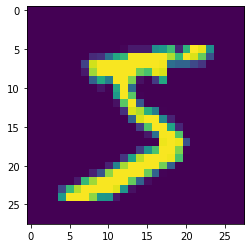

In [4]:
plt.imshow(x_train[0])
print(y_train[0])

<a id='pre-processing'></a>
### Data pre-processing 
#### Rershape the data
We convert the input data to (60000, 28, 28, 1) and float32.

In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [7]:
print(x_train.shape)

(60000, 28, 28, 1)


#### Normalize the data 
We  normalize our data values to the range [0, 1].

In [8]:
x_train /= 255
x_test /= 255

#### Label encoding 
Let's take a look at the labels for the first 10 training samples:

In [9]:
y_train.shape

(60000,)

In [10]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


The y_train and y_test data are not split into 10 distinct class labels, but rather are represented as a single array with the class values. We can fix this easily:

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
y_train_onehot = to_categorical(y_train,10)
y_test_onehot = to_categorical(y_test,10)

In [13]:
print(y_train_onehot.shape)

(60000, 10)


In [14]:
print(y_train_onehot[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


<a id='model'></a>
### Create the model

In [15]:
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten # Keras core layes
from tensorflow.python.keras.layers import Conv2D, MaxPool2D # Keras CNN layers

In [16]:
def create_model(inputShape, nClasses):
    # Model input
    inputs = Input(shape=inputShape)
     
    # Convolutional layers    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    # Fully connected Dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(nClasses, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Model')
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
        
    return model  

In [17]:
print('Input shape:',x_train.shape[1:])

Input shape: (28, 28, 1)


In [18]:
model = create_model(inputShape = x_train.shape[1:], nClasses = 10)
print('Output shape:', model.output_shape)

Output shape: (None, 10)


In [19]:
model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952

<a id='train'></a>
### Train the model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [22]:
model.fit(x_train, y_train_onehot, 
          batch_size=16,
          epochs=25,
          validation_data=(x_test,y_test_onehot),
          callbacks=[early_stop])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.1867 - accuracy: 0.9428 - val_loss: 0.0443 - val_accuracy: 0.9853
Epoch 2/25
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.0857 - accuracy: 0.9749 - val_loss: 0.0415 - val_accuracy: 0.9867
Epoch 3/25
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0651 - accuracy: 0.9801 - val_loss: 0.0334 - val_accuracy: 0.9895
Epoch 4/25
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0537 - accuracy: 0.9835 - val_loss: 0.0311 - val_accuracy: 0.9901
Epoch 5/25
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0447 - accuracy: 0.9868 - val_loss: 0.0312 - val_accuracy: 0.9910


<a id='evaluate'></a>
### Evaluate the model
#### Check if the model overfits:

- **Plot loss**

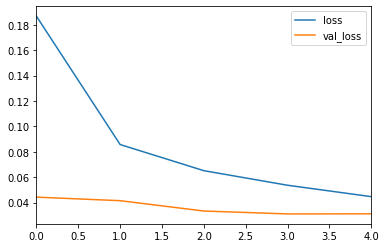

In [23]:
metrics = pd.DataFrame(model.history.history)
metrics[['loss', 'val_loss']].plot()

- **Plot accuracy**

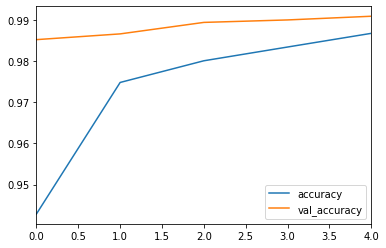

In [24]:
metrics[['accuracy', 'val_accuracy']].plot()

#### Show some metrics

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
predictions = model.predict(x_test, batch_size=16)
predictions = np.argmax(predictions,axis=1)

**[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)**

In [27]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



**[Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)**

In [28]:
confusion_matrix(y_test,predictions)

array([[ 978,    0,    0,    0,    0,    0,    0,    1,    1,    0],
       [   0, 1130,    2,    1,    0,    1,    1,    0,    0,    0],
       [   2,    2, 1021,    1,    2,    0,    0,    3,    1,    0],
       [   0,    0,    1, 1005,    0,    1,    0,    2,    1,    0],
       [   0,    0,    0,    0,  979,    0,    0,    0,    0,    3],
       [   1,    0,    0,    3,    0,  885,    1,    0,    1,    1],
       [   4,    3,    0,    0,    2,    3,  946,    0,    0,    0],
       [   1,    2,    6,    0,    0,    0,    0, 1015,    1,    3],
       [   4,    0,    0,    2,    1,    0,    1,    1,  961,    4],
       [   2,    0,    0,    0,   11,    1,    0,    2,    3,  990]])

**Heatmap**

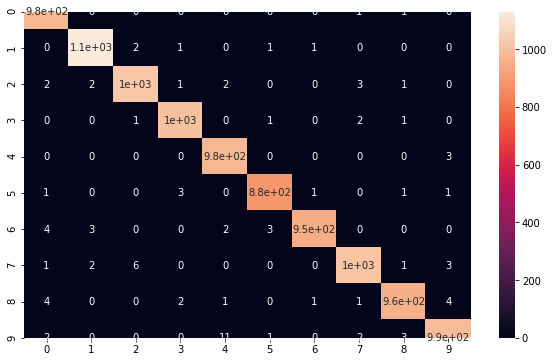

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)

<a id='predict'></a>
### Predicting a given image

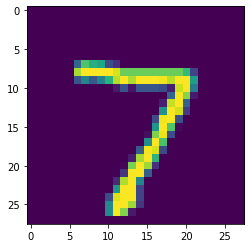

In [30]:
image = x_test[0].reshape(1,28,28,1)
plt.imshow(image[0,:,:,0])

In [31]:
prediction = model.predict(image)
prediction = np.argmax(prediction,axis=1)
print("The model says it's a", prediction[0])

The model says it's a 7


<a id='tfdata'></a>
## Keras with [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) from `numpy` arrays on the memory

<a id='MNIST2'></a>
### Load MNIST dataset

In [32]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


X and Y are usually prepared in float32 & int32

In [33]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [34]:
nClasses = 10
input_shape = (x_train.shape[1], x_train.shape[2])

<a id='dataset'></a>
### Create `tf.data.Dataset` from numpy arrays

**Parse function for data preprocessing**

Prepare train and test datasets using tf.data:
- Preprocess input data: float32 and normalize to the range [0, 1]
- Preprocess output data: convert 1-dimensional class arrays to 10-dimensional class matrices

In [35]:
def parse_function(x, y):
    x = tf.divide(x, 255.0)
    x = tf.reshape(x, [input_shape[0], input_shape[1], 1])
    y = tf.one_hot(y, nClasses)
    return x, y

**Creating `tf.data.Dataset` from numpy arrays**

The function starts by using the `tf.data.Dataset.from_tensor_slices` function to create a `tf.data.Dataset` representing slices of the array. The array is sliced across the first dimension. For example, an array containing the MNIST training data has a shape of *(60000, 28, 28)*. Passing this to from_tensor_slices returns a Dataset object containing *60000* slices, each one a *28x28* image.

In [36]:
def create_dataset(x_data, y_data, shuffle_size, batch_size):
    
    # This works with arrays as well
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(shuffle_size)
    
    # Set the batchsize
    dataset = dataset.batch(batch_size)

    return dataset

In [37]:
batch_size=16
data_train = create_dataset(x_train, y_train, shuffle_size=60000, batch_size=batch_size)
data_test = create_dataset(x_test, y_test, shuffle_size=10000, batch_size=batch_size)

In [38]:
data_train

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

<a id='train2'></a>
### Train the model

Number of steps for training & testing each epoch

In [39]:
nEpoch = 25
nStep_train = int(x_train.shape[0]/batch_size)
nStep_test = int(x_test.shape[0]/batch_size)

In [40]:
model = create_model(inputShape = (input_shape[0], input_shape[1], 1), nClasses = 10)

In [41]:
model.fit(data_train, 
          epochs=nEpoch, 
          validation_data=data_test, 
          steps_per_epoch=nStep_train, 
          validation_steps=nStep_test,
          callbacks=[early_stop])

Train for 3750 steps, validate for 625 steps
Epoch 1/25
3750/3750 [==============================] - 71s 19ms/step - loss: 0.1962 - accuracy: 0.9400 - val_loss: 0.0494 - val_accuracy: 0.9840
Epoch 2/25
3750/3750 [==============================] - 75s 20ms/step - loss: 0.0843 - accuracy: 0.9748 - val_loss: 0.0460 - val_accuracy: 0.9860
Epoch 3/25
3750/3750 [==============================] - 68s 18ms/step - loss: 0.0656 - accuracy: 0.9802 - val_loss: 0.0362 - val_accuracy: 0.9881
Epoch 4/25
3750/3750 [==============================] - 75s 20ms/step - loss: 0.0544 - accuracy: 0.9832 - val_loss: 0.0463 - val_accuracy: 0.9859


<a id='predict2'></a>
### Predicting a given image

In [42]:
def parse_function_val(x):
    x = tf.divide(x, 255.0)
    x = tf.reshape(x, [input_shape[0], input_shape[1], 1])
    return x

In [43]:
def create_dataset_val(x_data, batch_size):
    
    # This works with arrays as well
    dataset = tf.data.Dataset.from_tensor_slices(x_data)
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function_val, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the batchsize
    dataset = dataset.batch(batch_size)
    
    return dataset

In [44]:
batch_size=16
data_val = create_dataset_val(x_test, batch_size)

In [45]:
y_out = model.predict(data_val, steps=nStep_test)
y_out = np.argmax(y_out,axis=1)

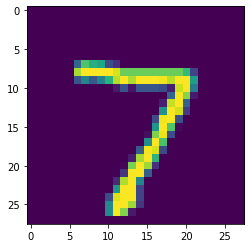

In [46]:
plt.imshow(x_test[0,:,:])

In [47]:
print("The model says it's a", y_out[0])

The model says it's a 7


<a id='tfrecords'></a>
## Keras with [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) from [`TFRecords`](https://www.tensorflow.org/tutorials/load_data/tfrecord)

<a id='write'></a>
### Write a TFRecord file
Learn more about TFRecords here:
- [How to train a Keras model on TFRecord files](https://keras.io/examples/keras_recipes/tfrecord/)
- [Anatomy of TFRecord](https://jongwook.kim/blog/Anatomy-of-TFRecord.html)
- [Speeding up Keras with tfrecord datasets](https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36)

In [48]:
# Helperfunctions to make your feature definition more readable
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(array):
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def writeTFRecord(filename, image, label):
    """
    filename : string
        TFRecord file name. 
    image : float
         Input numpy array.
    image : int
         Output numpy array.
    """
    
    # create filewriter
    writer = tf.io.TFRecordWriter(filename)
    
    for i in range(label.shape[0]):
        
        # Define the features of your tfrecord       
        feature = {'image':  _float_feature(image[i]),
                   'label':  _int64_feature(int(label[i]))}
        
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        # Serialize to string and write to file
        writer.write(example.SerializeToString())
        
    writer.close()

**Load MNIST dataset**

In [49]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [50]:
nClasses = 10
nData_train = x_train.shape[0]
nData_test = x_test.shape[0]
nDimIn = x_train.shape[1]*x_train.shape[2]
input_shape = (x_train.shape[1], x_train.shape[2])

Data should have 1D

In [51]:
x_train_vec = x_train.reshape([nData_train,-1])
x_test_vec = x_test.reshape([nData_test,-1])
print(x_train_vec.shape, x_test_vec.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


In [52]:
file_train = '../../Data/mnist_train.tfrecords'
file_test = '../../Data/mnist_test.tfrecords'

writeTFRecord(file_train, x_train_vec, y_train)
writeTFRecord(file_test, x_test_vec, y_test)

<a id='read'></a>
### Read a TFRecord file

**Get number of records**

In [53]:
nRecords = 0

for record in tf.data.TFRecordDataset("../../Data/mnist_train.tfrecords"):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    
    nRecords += 1
    
print('Number of Records:', nRecords)

Number of Records: 60000


**Read example record**

[5]


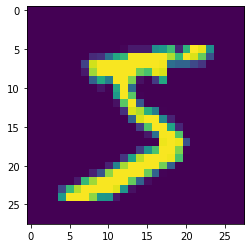

In [54]:
for record in tf.data.TFRecordDataset("../../Data/mnist_train.tfrecords").take(1):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    
image = np.array(example.features.feature['image'].float_list.value).reshape(28, 28, 1)
label = np.array(example.features.feature['label'].int64_list.value)

plt.imshow(image[:,:,0])
print(label)

<a id='dataset2'></a>
### Create `tf.data.Dataset` from TFRecords

**Parse function for data preprocessing**

In [55]:
def parse_function(proto):
    
    features = {'image': tf.io.FixedLenFeature([input_shape[0], input_shape[1], 1], tf.float32),
                'label': tf.io.FixedLenFeature([], tf.int64)}
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features)
    
    # Turn your saved image string into an array
    image = parsed_features['image']
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    # Create a one hot array for your labels
    label = tf.one_hot(parsed_features['label'], nClasses)
    
    return image, label

**Prepare train and test datasets using tf.data**

In [56]:
def create_dataset(file_path, shuffle_size, batch_size):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(file_path)
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(shuffle_size)
    
    # Set the batchsize
    dataset = dataset.batch(batch_size)
    
    return dataset

In [57]:
batch_size = 16

dataset_train = create_dataset(file_path='../../Data/mnist_train.tfrecords', shuffle_size=60000, batch_size=batch_size)
dataset_test = create_dataset(file_path='../../Data/mnist_test.tfrecords', shuffle_size=10000, batch_size=batch_size)

<a id='train3'></a>
### Train the model

In [58]:
nEpoch = 25
nStep_train = (int)(x_train.shape[0]/batchSize)
nStep_test = (int)(x_test.shape[0]/batchSize)

In [59]:
model = create_model(inputShape = (input_shape[0], input_shape[1], 1), nClasses = 10)

In [60]:
model.fit(dataset_train, 
          epochs=nEpoch, 
          validation_data=dataset_test, 
          steps_per_epoch=nStep_train, 
          validation_steps=nStep_test,
          callbacks=[early_stop])

Train for 3750 steps, validate for 625 steps
Epoch 1/25
3750/3750 [==============================] - 81s 21ms/step - loss: 0.1866 - accuracy: 0.9428 - val_loss: 0.0496 - val_accuracy: 0.9832
Epoch 2/25
3750/3750 [==============================] - 66s 18ms/step - loss: 0.0847 - accuracy: 0.9754 - val_loss: 0.0426 - val_accuracy: 0.9860
Epoch 3/25
3750/3750 [==============================] - 67s 18ms/step - loss: 0.0683 - accuracy: 0.9793 - val_loss: 0.0397 - val_accuracy: 0.9867
Epoch 4/25
3750/3750 [==============================] - 72s 19ms/step - loss: 0.0532 - accuracy: 0.9833 - val_loss: 0.0378 - val_accuracy: 0.9884
Epoch 5/25
3750/3750 [==============================] - 72s 19ms/step - loss: 0.0470 - accuracy: 0.9857 - val_loss: 0.0306 - val_accuracy: 0.9912
Epoch 6/25
3750/3750 [==============================] - 76s 20ms/step - loss: 0.0390 - accuracy: 0.9877 - val_loss: 0.0301 - val_accuracy: 0.9904
Epoch 7/25
3750/3750 [==============================] - 67s 18ms/step - loss: 0

<a id='predict3'></a>
### Predicting a given image

In [61]:
def parse_function_val(proto):
    
    features = {'image': tf.io.FixedLenFeature([input_shape[0], input_shape[1], 1], tf.float32)}
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, features)
    
    # Turn your saved image string into an array
    image = parsed_features['image']
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    return image

In [62]:
def create_dataset_val(file_path, batch_size):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(file_path)
    
    # Maps the preprocessing function. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function_val, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the batchsize
    dataset = dataset.batch(batch_size)
    
    return dataset

In [63]:
batch_size = 16
dataset_val = create_dataset_val(file_path='../../Data/mnist_test.tfrecords', batch_size=batch_size)

In [64]:
y_out = model.predict(dataset_val, steps=nStep_test)
y_out = np.argmax(y_out,axis=1)

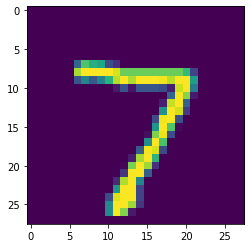

In [65]:
plt.imshow(x_test[0,:,:])

In [66]:
print("The model says it's a", y_out[0])

The model says it's a 7


<a id='cloud'></a>
## Accessing `TFRecords` on Google Cloud Storage

<a id='upload'></a>
### Upload `TFRecords` to Google Cloud 

In [67]:
from google.cloud import storage

In [98]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    
    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

**Upload training dataset**

In [102]:
upload_blob('geo-ai', file_train, 'MNIST/Data/mnist_train.tfrecords')

RefreshError: ('invalid_grant: Invalid grant: account not found', '{"error":"invalid_grant","error_description":"Invalid grant: account not found"}')

**Upload test dataset**

In [ ]:
upload_blob('geo-ai', file_test, 'MNIST/Data/mnist_test.tfrecords')

<a id='read2'></a>
### Read a TFRecord file

**Get number of records**

In [100]:
nRecords = 0

for record in tf.data.TFRecordDataset("gs://geo-ai/MNIST/Data/mnist_train.tfrecords"):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    
    nRecords += 1
    
print('Number of Records:', nRecords)

Number of Records: 60000


**Read example record**

[5]


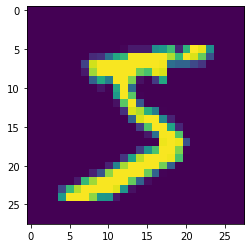

In [101]:
for record in tf.data.TFRecordDataset("gs://geo-ai/MNIST/Data/mnist_train.tfrecords").take(1):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    
image = np.array(example.features.feature['image'].float_list.value).reshape(28, 28, 1)
label = np.array(example.features.feature['label'].int64_list.value)

plt.imshow(image[:,:,0])
print(label)